In [1]:
import sklearn
import rootutils
import torch_geometric
rootutils.setup_root("./", indicator=".project-root", pythonpath=True)

import matplotlib.pyplot as plt
import torch
import hydra
from topobenchmarkx.data.loaders.graph import *
from topobenchmarkx.data.loaders.hypergraph import *
from topobenchmarkx.data.preprocessor import PreProcessor
from topobenchmarkx.utils.config_resolvers import (
    get_default_transform,
    get_monitor_metric,
    get_monitor_mode,
    infer_in_channels,
)
import numpy as np
from topobenchmarkx.dataloader import TBXDataloader
import matplotlib.pyplot as plt
from topobenchmarkx.transforms.data_manipulations import TuneDecisionTree, InferKNNConnectivitySKLEARN
from sklearn.metrics import jaccard_score
from tqdm import tqdm  # Import tqdm
%load_ext autoreload
%autoreload 2

hydra.initialize(config_path="../configs", job_name="job")

cfg = hydra.compose(config_name="run.yaml", overrides=["model=hypergraph/unignn2", "dataset=graph/roman_empire"], return_hydra_config=True)
loader = hydra.utils.instantiate(cfg.dataset.loader)

dataset, dataset_dir = loader.load()

# Apply transform
processed_dataset = PreProcessor(dataset, dataset_dir, cfg.transforms)

dataset_train, dataset_val, dataset_test = (
        processed_dataset.load_dataset_splits(cfg.dataset.split_params)
    )
    
#data = processed_dataset.data

datamodule = TBXDataloader(
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            dataset_test=dataset_test,
            **cfg.dataset.get("dataloader_params", {}),
        )

data = next(iter(datamodule.train_dataloader()))

Transform parameters are the same, using existing data_dir: /home/lev/projects/TopoBenchmark/datasets/graph/heterophilic/roman_empire/graph2hypergraph_lifting/2796495657


/tmp/ipykernel_1476899/381723440.py:27: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="../configs", job_name="job")


In [2]:
import numpy as np
import matplotlib.pyplot as plt


import numpy as np
import torch
import torch_geometric
import matplotlib.pyplot as plt

from torch_geometric.utils import to_dense_adj, homophily
from typing import Dict, List, Any
import torch
from torch_geometric.utils import to_dense_adj

def calculate_metrics(
    edge_index: torch.Tensor, 
    y: torch.Tensor,
) -> Dict[str, Any]:
    """
    Calculate graph homophily and neighborhood metrics.

    Args:
        edge_index (torch.Tensor): Graph edge index
        y (torch.Tensor): Node labels

    Returns:
        Dictionary containing graph metrics
    """
    
    metrics = {
        'node_homophily': homophily(edge_index, y, method='node'),
        'edge_homophily': homophily(edge_index, y, method='edge'),
        'edge_insensitive_homophily': homophily(edge_index, y, method='edge_insensitive'),
        'avg_neighbors': to_dense_adj(edge_index).squeeze(0).sum(1).mean().item(),
        'num_edges': edge_index.size(1)
    }
    
    return metrics

def create_knn_graph_mettics(
    queries: torch.Tensor, 
    y: torch.Tensor, 
    knn_model, 
    k_values: List[int],
    source_node_idx=None, 
) -> Dict[str, Any]:
    """
    Create KNN graphs for different k values and calculate metrics.

    Args:
        queries (torch.Tensor): Input query points
        y (torch.Tensor): Node labels
        knn_model: K-nearest neighbors model
        k_values (List[int]): List of k values to explore

    Returns:
        Dictionary containing metrics for different k values and final edge index
    """
    # Calculate metrics for each k value
    metrics = {
        k: calculate_metrics(
            knn_model.get_kneighbors(
                X=queries, 
                n_neighbors=k, 
                source_node_idx=source_node_idx,
            ), 
            y
        ) for k in tqdm(k_values)
    }

    # Prepare the return dictionary
    return metrics


def plot_knn_metrics(metrics_dict, k_values=None):
    """
    Create a plot of KNN graph metrics.

    Args:
        metrics_dict (dict): Dictionary of metrics for different k values
        k_values (array-like, optional): Specific k values to plot. 
                                         If None, uses keys from metrics_dict.
    """
    # Use dictionary keys if k_values not provided
    if k_values is None:
        k_values = list(metrics_dict.keys())
    
    # Extract metrics for plotting
    node_homophily = [metrics_dict[k]['node_homophily'] for k in k_values]
    edge_homophily = [metrics_dict[k]['edge_homophily'] for k in k_values]
    edge_insensitive_homophily = [metrics_dict[k]['edge_insensitive_homophily'] for k in k_values]
    avg_neighbors = [metrics_dict[k]['avg_neighbors'] for k in k_values]
    num_edges = [metrics_dict[k]['num_edges'] for k in k_values]

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Plot homophily metrics on primary y-axis
    plt.plot(k_values, node_homophily, 'b-', label='Node Homophily')
    plt.plot(k_values, edge_homophily, 'r-', label='Edge Homophily')
    plt.plot(k_values, edge_insensitive_homophily, 'g-', label='Edge Insensitive Homophily')

    plt.legend(loc='upper right')

    # Add average neighbors on secondary y-axis
    ax2 = plt.gca().twinx()
    ax2.plot(k_values, avg_neighbors, 'k--', label='Avg Neighbors')
    ax2.set_ylabel('Average Number of Neighbors', color='k')

    # Customize the plot
    plt.gca().set_xlabel('Number of Neighbors (k)')
    plt.gca().set_ylabel('Homophily Score')
    plt.title('Impact of k-NN Parameters on Graph Metrics')

    # Combine legends from both axes
    lines1, labels1 = plt.gca().get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nKNN Graph Statistics:")
    print(f"Best Node Homophily: {max(node_homophily):.4f}")
    print(f"Best Edge Homophily: {max(edge_homophily):.4f}")
    print(f"Best Edge Insensitive Homophily: {max(edge_insensitive_homophily):.4f}")

    # print("\nNumber of edges for selected k values:")
    # for k, edges in zip(k_values, num_edges):
    #     print(f"k={k}: {edges} edges")

# KNN in the space of not deep (TUNNED) tree

Fitting 2 folds for each of 768 candidates, totalling 1536 fits


Train score 0.7004677433589268
Validation score 0.6174757281553398
k-NN model has been fitted successfully.


100%|██████████| 5/5 [10:16<00:00, 123.30s/it]


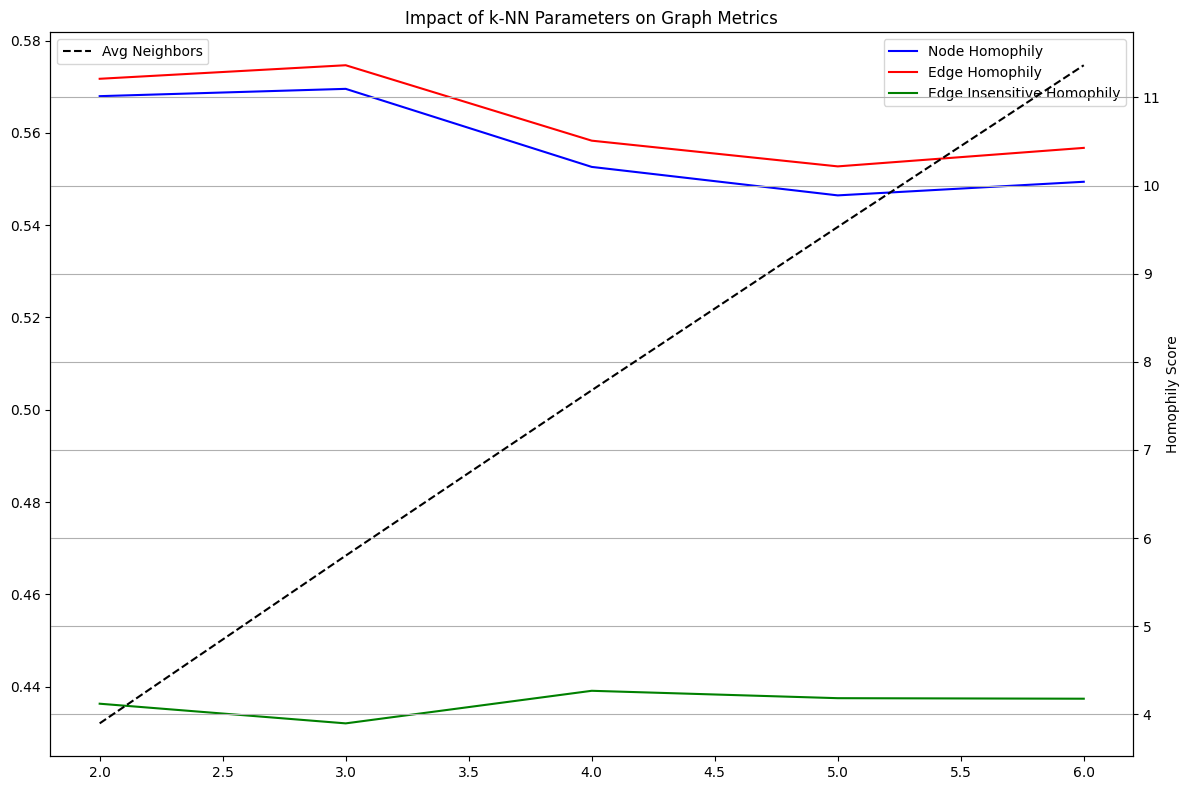


KNN Graph Statistics:
Best Node Homophily: 0.5695
Best Edge Homophily: 0.5747
Best Edge Insensitive Homophily: 0.4391


In [3]:
dt_transform = TuneDecisionTree()
data = dt_transform(data)

tunned_tree = data.tree_model
H_tree = data.H_tree


knn = InferKNNConnectivitySKLEARN()
data = knn(data)

metrics = create_knn_graph_mettics(
    queries = data.H_tree,  
    y = data.y,
    knn_model = knn,
    k_values = range(2, 7, 1)
    )

plot_knn_metrics(metrics)

# KNN in the space of DEEP  (not tunned) tree

Train score 0.8277292383726061
Validation score 0.612180052956752
k-NN model has been fitted successfully.


100%|██████████| 3/3 [25:20<00:00, 506.68s/it]


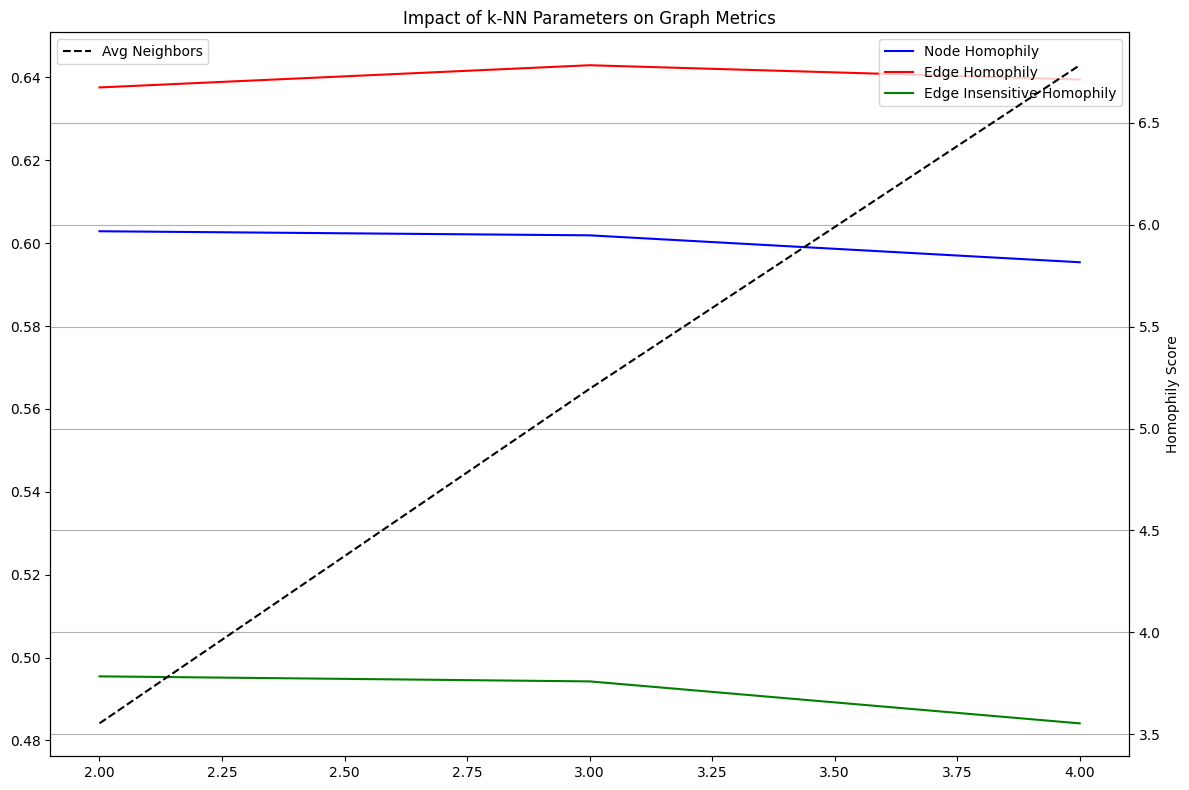


KNN Graph Statistics:
Best Node Homophily: 0.6029
Best Edge Homophily: 0.6430
Best Edge Insensitive Homophily: 0.4955


In [4]:
dt_transform = TuneDecisionTree()
data = dt_transform.base_param_tree(data, random_state=0)

tunned_tree = data.tree_model
H_tree = data.H_tree


knn = InferKNNConnectivitySKLEARN()
data = knn(data)

metrics = create_knn_graph_mettics(
    queries = data.H_tree,  
    y = data.y,
    knn_model = knn,
    k_values = range(2, 5, 1),
    )

plot_knn_metrics(metrics)

In [6]:
H_tree.shape

torch.Size([22662, 3659])

### Solely val and test sents as quesries

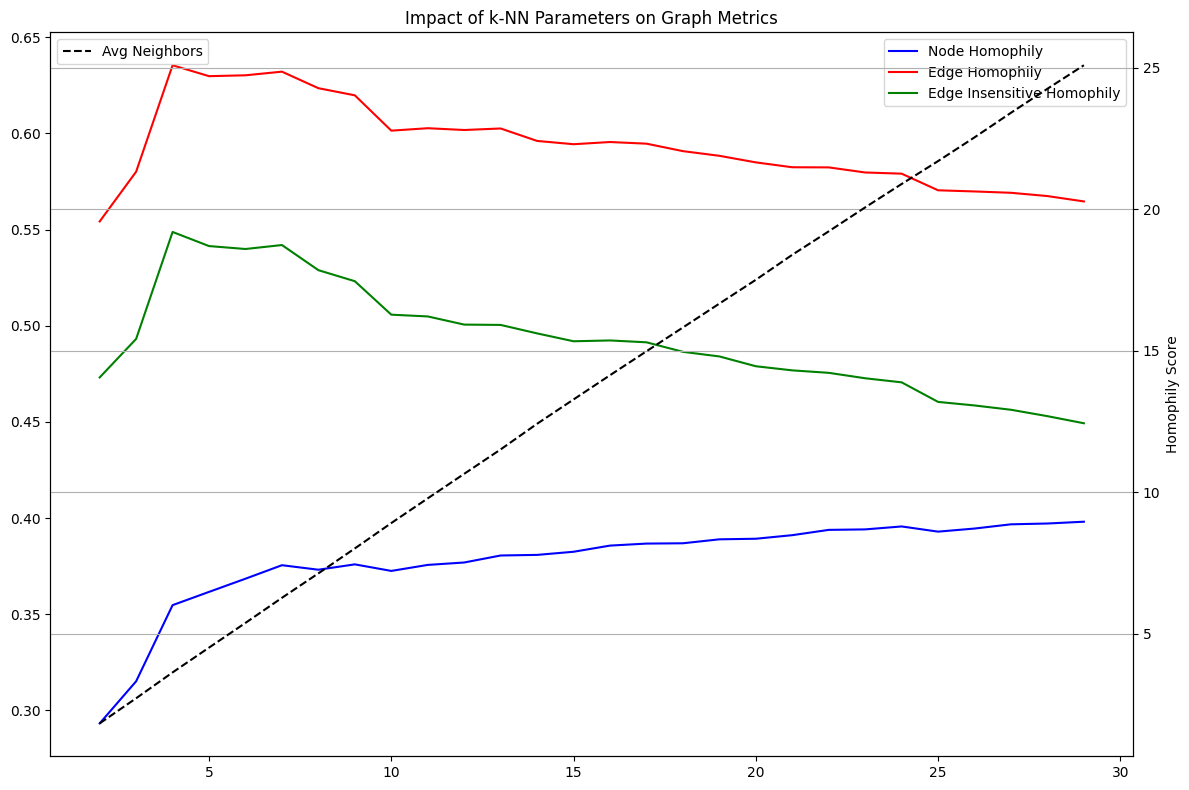


KNN Graph Statistics:
Best Node Homophily: 0.3981
Best Edge Homophily: 0.6354
Best Edge Insensitive Homophily: 0.5487


In [ ]:
source_node_idx = torch.concat([data.val_mask, data.test_mask])
metrics = create_knn_graph_mettics(
    queries = data.H_tree[source_node_idx],  
    y = data.y,
    knn_model = knn,
    k_values = range(2, 30, 1),
    source_node_idx=source_node_idx,
    )

plot_knn_metrics(metrics)

# KNN in the space of not deep (TUNNED) tree with JACCARD distance

In [ ]:
dt_transform = TuneDecisionTree()
data = dt_transform(data)

tunned_tree = data.tree_model
H_tree = data.H_tree


knn = InferKNNConnectivitySKLEARN(metric=lambda a,b: 1 - jaccard_score(a,b))
data = knn(data)

metrics = create_knn_graph_mettics(
    queries = data.H_tree,  
    y = data.y,
    knn_model = knn,
    k_values = range(2, 30, 5)
    )
    

plot_knn_metrics(metrics)

# KNN in the space of DEEP (not tunned) tree with JACCARD distance (that is very slow)

In [ ]:

# dt_transform = TuneDecisionTree()
# data = dt_transform.base_param_tree(data, random_state=0)

# tunned_tree = data.tree_model
# H_tree = data.H_tree


# knn = InferKNNConnectivitySKLEARN(metric=lambda a,b: 1 - jaccard_score(a,b))
# data = knn(data)

# metrics = create_knn_graph_mettics(
#     queries = data.H_tree,  
#     y = data.y,
#     knn_model = knn,
#     k_values = range(2, 30, 1),
#     )

# plot_knn_metrics(metrics)

# KNN in feature space

k-NN model has been fitted successfully.


100%|██████████| 28/28 [03:06<00:00,  6.68s/it]


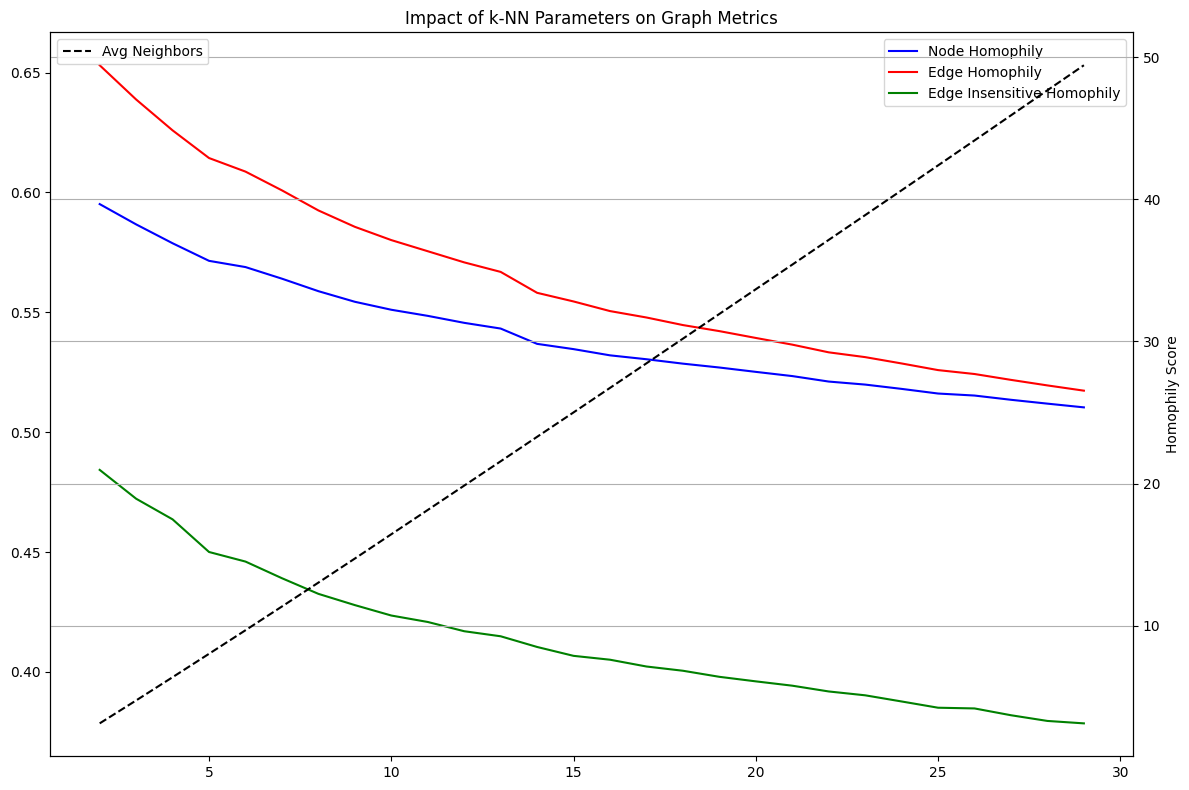


KNN Graph Statistics:
Best Node Homophily: 0.5951
Best Edge Homophily: 0.6531
Best Edge Insensitive Homophily: 0.4843


In [3]:
knn = InferKNNConnectivitySKLEARN(fit_key='x', query_key='x', metric='l2')
data = knn(data)

metrics = create_knn_graph_mettics(
    queries = data.x,  
    y = data.y,
    knn_model = knn,
    k_values = range(2, 30, 1)
    )

plot_knn_metrics(metrics)

OLD

In [34]:
dtree = sklearn.tree.DecisionTreeClassifier(
    #min_samples_leaf=5,
    #min_samples_split=50,
    #max_features='sqrt',
)

x = data.x[data.train_mask].numpy()
y = data.y[data.train_mask].numpy()

dtree.fit(x, y)
dpath = dtree.decision_path(data.x.numpy())

In [4]:
x.shape

(1354, 1433)

In [ ]:
dpath.shape 

(22662, 3659)

In [ ]:
# from sklearn.metrics import jaccard_score

# H = np.array(dpath.todense())
# H_set = []
# for row in H:
#     H_set.append(np.nonzero(row)[0])

# scores = []   
# for i in range(len(H_set)):
#     len_i = len(H_set[i])
#     for j in range(len(H_set)):
#         len_j = len(H_set[j])
        
#         if len_j > len_i:
#             score = jaccard_score(H_set[i], H_set[j][:len_i], average='micro')
#         elif len_j < len_i:
#             score =jaccard_score(H_set[i][:len_j], H_set[j], average='micro')
#         else:
#             score = jaccard_score(H_set[i], H_set[j], average='micro')
#         scores.append(score)

# plt.hist(scores, bins=100)


    
# H = np.array(dpath.todense())

# scores = []   
# for i in range(len(H)):
#     for j in range(len(H)):        
#         score = jaccard_score(H[i], H[j])
#         scores.append(score)

# plt.hist(scores, bins=100)

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Split train and validation data
x_train = data.x[data.train_mask].numpy()
y_train = data.y[data.train_mask].numpy()
x_val = data.x[data.val_mask].numpy()
y_val = data.y[data.val_mask].numpy()

# Define the parameter grid for DecisionTreeClassifier
param_grid = {
    'criterion': ['gini', 'entropy'],                # Splitting criterion
    'max_depth': [None, 5, 10, 20],                  # Maximum tree depth
    'min_samples_split': [2, 5, 10, 20],             # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 5, 10],               # Minimum samples in a leaf node
    'max_features': [None, 'sqrt', 'log2'],          # Features to consider for best split
    'class_weight': [None, 'balanced'],              # Balance class weights
}

# Initialize a DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    verbose=1   # Display progress
)

# Perform the search on the training data
grid_search.fit(x_train, y_train)

# Get the best estimator and hyperparameters
best_tree = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate on the validation data
y_pred = best_tree.predict(x_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy with Best Hyperparameters: {accuracy:.4f}")


Fitting 5 folds for each of 768 candidates, totalling 3840 fits


Best Hyperparameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Validation Accuracy with Best Hyperparameters: 0.6115


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Split train and validation data
x_train = data.x[data.train_mask].numpy()
y_train = data.y[data.train_mask].numpy()
x_val = data.x[data.val_mask].numpy()
y_val = data.y[data.val_mask].numpy()

# Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [30],                 # Number of trees in the forest
    'criterion': ['gini', 'entropy'],              # Splitting criterion
    'max_depth': [None, 3, 5], #[ None, 5, 10],                # Maximum tree depth
    'min_samples_split': [2, 5],           # Minimum samples to split a node
    'min_samples_leaf': [1, 2],             # Minimum samples in a leaf node
    'max_features': ['sqrt', 'log2', None],        # Features to consider for best split
    'class_weight': [None, 'balanced'],            # Balance class weights
}


# Initialize a RandomForestClassifier
rforest = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=rforest,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    verbose=1   # Display progress
)

# Perform the search on the training data
grid_search.fit(x_train, y_train)

# Get the best estimator and hyperparameters
best_forest = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Hyperparameters for Random Forest:", best_params)

# Evaluate on the validation data
y_pred = best_forest.predict(x_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy with Best Hyperparameters: {accuracy:.4f}")


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Hyperparameters for Random Forest: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 30}
Validation Accuracy with Best Hyperparameters: 0.6942


In [8]:
len(best_forest.estimators_)

30

In [9]:
len(best_forest.estimators_[0].decision_path(data.x).shape)

2

In [10]:
best_forest.estimators_[0].decision_path(data.x).todense().shape

(22662, 59)

### HH.T

H.shape (2708, 707)


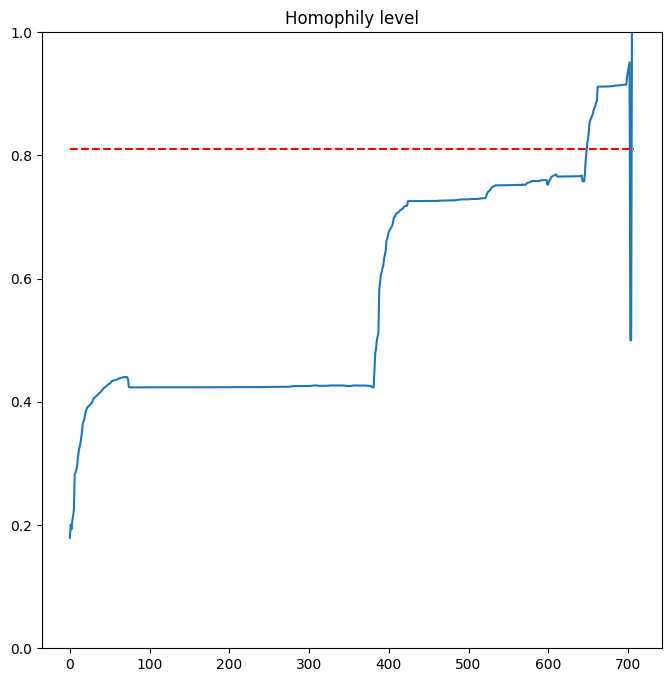

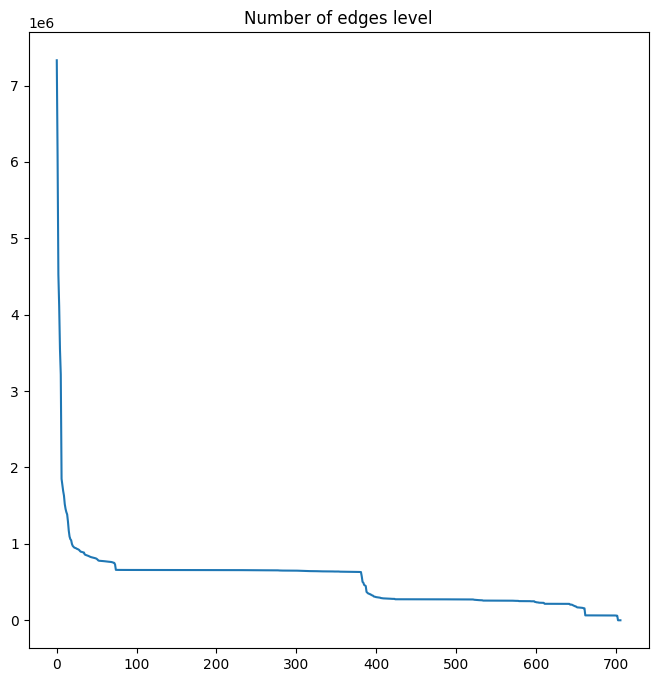

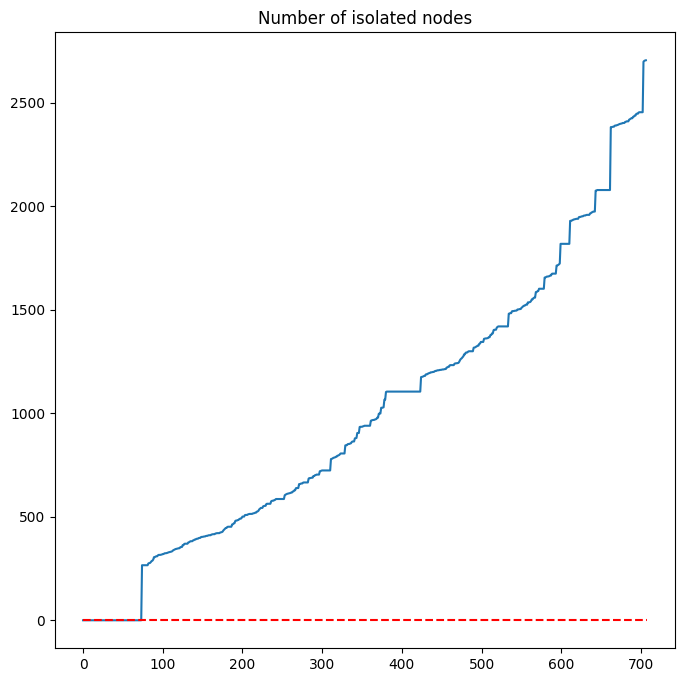

In [9]:

H = dpath.todense()[:,:]
print('H.shape', H.shape)
sequence, num_edges, num_isolated_nodes = [], [], []
for i in range(0, H.shape[1], 1):
    H_temp = torch.Tensor(H[:,i:])
    A = H_temp @ H_temp.T
    edge_index = (A>0).nonzero().T
    edge_index = torch_geometric.utils.remove_self_loops(edge_index)[0]
    edge_index = torch_geometric.utils.to_undirected(edge_index)
    
    # Statistics    
    num_isolated_nodes.append((A.sum(0)==0).sum())
    num_edges.append(edge_index.shape[1])
    sequence.append(torch_geometric.utils.homophily(edge_index, data.y))
    

plt.plot(sequence)
# Plot red dashed line from one y value
init_homophily = torch_geometric.utils.homophily(data.edge_index, data.y)
plt.plot([0, len(sequence)], [init_homophily, init_homophily], 'r--')
plt.ylim([0, 1])
plt.title('Homophily level')
plt.show()

plt.plot(num_edges)
plt.title('Number of edges level')
plt.show()


plt.plot(num_isolated_nodes)
init_isolated_nodes = (torch_geometric.utils.to_dense_adj(data.edge_index).squeeze(0).sum(0)==0).sum()
plt.plot([0, len(num_isolated_nodes)], [init_isolated_nodes, init_isolated_nodes], 'r--')

plt.title('Number of isolated nodes')
plt.show()



### Substring

In [11]:
import torch

def largest_substring_match_tensor(seq1, seq2, threshold):
    """
    Checks if the first `threshold` elements of seq1 and seq2 match exactly.
    Returns False if either sequence is all zeros.

    Args:
        seq1, seq2 (torch.Tensor): 1D tensors representing rows.
        threshold (int): Minimum match length required.

    Returns:
        bool: True if the first `threshold` elements match exactly, False otherwise.
    """
    # Check if either sequence is all zeros
    if torch.all(seq1 == 0) or torch.all(seq2 == 0):
        return False

    # Check for prefix match of length `threshold`
    if len(seq1) >= threshold and len(seq2) >= threshold:
        return torch.all(seq1[:threshold] == seq2[:threshold])

    return False

def construct_edge_index_optimized(H, threshold):
    """
    Constructs edge_index for a similarity graph using prefix match and tensor optimizations.
    Checks for rows of all zeros and skips them.

    Args:
        H (torch.Tensor): Decision matrix (N x K), where each row represents a data point.
        threshold (int): Minimum matching substring length to add an edge.

    Returns:
        edge_index (torch.Tensor): A 2 x E matrix, where E is the number of edges.
    """
    N = H.size(0)  # Number of rows
    edges = []

    for i in range(N):
        for j in range(i + 1, N):
            if largest_substring_match_tensor(H[i], H[j], threshold):
                edges.append((i, j))
                edges.append((j, i))  # For undirected graph

    # Convert edges to edge_index tensor
    edge_index = torch.tensor(edges, dtype=torch.long).t() if edges else torch.empty((2, 0), dtype=torch.long)
    return edge_index




### Single Decision Tree:

In [4]:
import numpy as np
import torch
import torch_geometric
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from torch_geometric.utils import to_dense_adj, homophily

In [13]:
# Get decision paths from each tree
idx = torch.concatenate([data.val_mask, data.test_mask])
X = data.x[idx]
y = data.y[idx] 
 
dpath = best_tree.decision_path(X.numpy())
H = torch.Tensor(dpath.todense())


edge_index = construct_edge_index_optimized(H[:,:], H.shape[1])
node_homo = homophily(edge_index, y, method='node')
edge_homo = homophily(edge_index, y, method='edge')
edge_insensitive_homo = homophily(edge_index, y, method='edge_insensitive')
avg_neigh = to_dense_adj(edge_index).squeeze(0).sum(1).mean().item()

print(f"Node Homophily: {node_homo:.4f}")
print(f"Edge Homophily: {edge_homo:.4f}")
print(f"Edge Insensitive Homophily: {edge_insensitive_homo:.4f}")
print(f"Average Neighbors: {avg_neigh:.2f}")

NameError: name 'best_tree' is not defined

### BASELINE

In [14]:
# dpath = best_tree.decision_path(data.x.numpy())
# H = torch.Tensor(dpath.todense())

# BASELINE
edge_index = data.edge_index
node_homo = homophily(edge_index, data.y, method='node')
edge_homo = homophily(edge_index, data.y, method='edge')
edge_insensitive_homo = homophily(edge_index, data.y, method='edge_insensitive')
avg_neigh = to_dense_adj(edge_index).squeeze(0).sum(1).mean().item()

print(f"Node Homophily: {node_homo:.4f}")
print(f"Edge Homophily: {edge_homo:.4f}")
print(f"Edge Insensitive Homophily: {edge_insensitive_homo:.4f}")
print(f"Average Neighbors: {avg_neigh:.2f}")
print(f"num_edges:", edge_index.shape[1])

Node Homophily: 0.0460
Edge Homophily: 0.0469
Edge Insensitive Homophily: 0.0208
Average Neighbors: 2.91
num_edges: 65854


###  Forest

In [15]:
# Get decision paths from each tree
idx = torch.concatenate([data.val_mask, data.test_mask])
X = data.x[idx]
y = data.y[idx]
dec_trees = [np.array(best_forest.estimators_[i].decision_path(X).todense()[:,:]) 
             for i in range(len(best_forest.estimators_))]
dec_trees_shapes = [tree.shape[1] for tree in dec_trees]

# Create concatenated decision paths matrix
H = torch.Tensor(np.concatenate(dec_trees, axis=1))

# Calculate cumulative sums of tree shapes
cumsum_shapes = [np.sum(dec_trees_shapes[:i]) for i in range(1, len(dec_trees_shapes))]

# Prepare arrays to store metrics
node_homophily = []
edge_homophily = []
edge_insensitive_homophily = []
avg_neighbors = []

# Calculate metrics for each threshold
for th in cumsum_shapes:
    edge_index = construct_edge_index_optimized(H[:,:], th)
    
    # Calculate metrics
    node_homo = homophily(edge_index, y, method='node')
    edge_homo = homophily(edge_index, y, method='edge')
    edge_insensitive_homo = homophily(edge_index, y, method='edge_insensitive')
    avg_neigh = to_dense_adj(edge_index).squeeze(0).sum(1).mean().item()
    
    # Store results
    node_homophily.append(node_homo)
    edge_homophily.append(edge_homo)
    edge_insensitive_homophily.append(edge_insensitive_homo)
    avg_neighbors.append(avg_neigh)

    # Print progress and current metrics
    print(f"Threshold: {th:.2f}")
    print(f"Node Homophily: {node_homo:.4f}")
    print(f"Edge Homophily: {edge_homo:.4f}")
    print(f"Edge Insensitive Homophily: {edge_insensitive_homo:.4f}")
    print(f"Average Neighbors: {avg_neigh:.2f}")
    print("-" * 50)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot homophily metrics on primary y-axis
plt.plot(cumsum_shapes, node_homophily, 'b-', label='Node Homophily')
plt.plot(cumsum_shapes, edge_homophily, 'r-', label='Edge Homophily')
plt.plot(cumsum_shapes, edge_insensitive_homophily, 'g-', label='Edge Insensitive Homophily')
plt.ylabel('Homophily Score')
plt.legend()

# Add average neighbors on secondary y-axis
ax2 = plt.gca().twinx()
ax2.plot(cumsum_shapes, avg_neighbors, 'k--', label='Avg Neighbors')
ax2.set_ylabel('Average Number of Neighbors', color='k')

# Customize the plot
plt.gca().set_xlabel('Threshold (Cumulative Sum of Tree Shapes)')
plt.gca().set_ylabel('Average Number of Neighbors')
plt.title('Impact of Threshold on Graph Metrics')

# Combine legends from both axes
lines1, labels1 = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Add grid and adjust layout
plt.grid(True)
plt.tight_layout()
plt.legend()
# Save the plot
#plt.savefig('forest_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Best Node Homophily: {max(node_homophily):.4f} at threshold {cumsum_shapes[np.argmax(node_homophily)]:.2f}")
print(f"Best Edge Homophily: {max(edge_homophily):.4f} at threshold {cumsum_shapes[np.argmax(edge_homophily)]:.2f}")
print(f"Best Edge Insensitive Homophily: {max(edge_insensitive_homophily):.4f} at threshold {cumsum_shapes[np.argmax(edge_insensitive_homophily)]:.2f}")

Threshold: 59.00
Node Homophily: 0.4344
Edge Homophily: 0.3956
Edge Insensitive Homophily: 0.2785
Average Neighbors: 867.46
--------------------------------------------------


KeyboardInterrupt: 

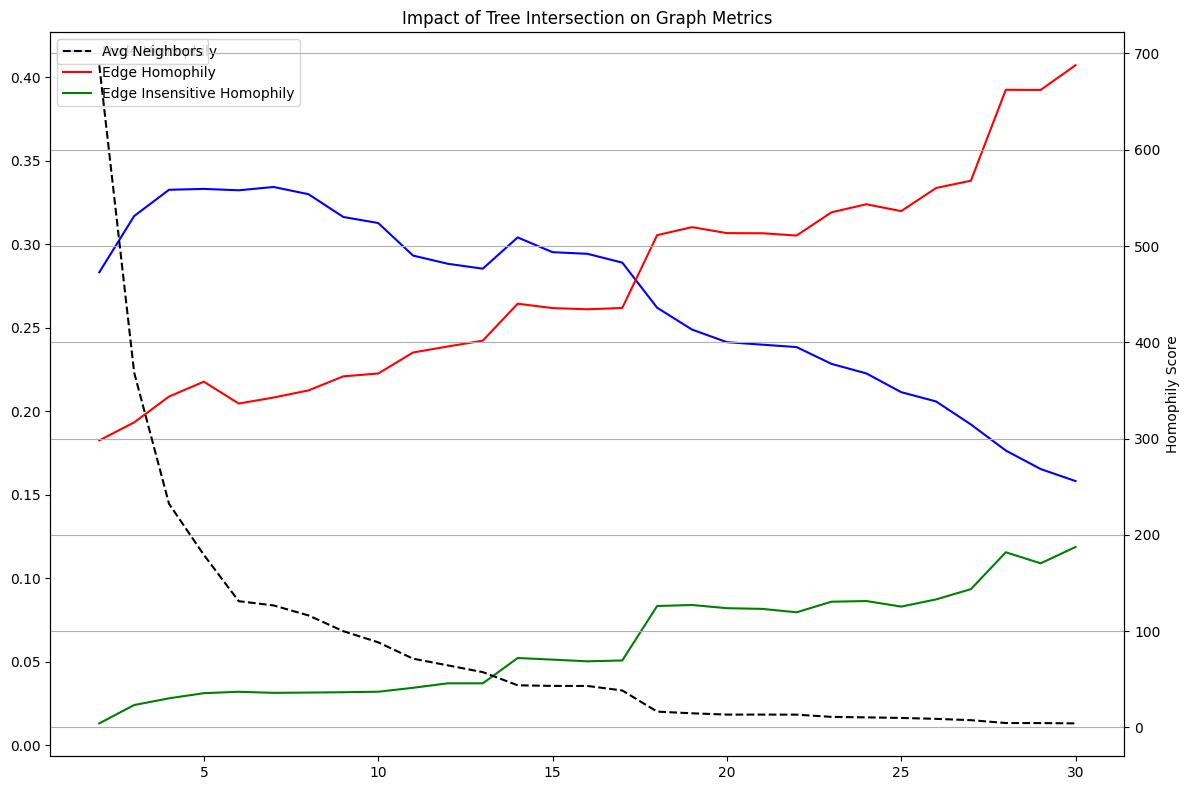


Intersection Method Statistics:
Best Node Homophily: 0.3344
Best Edge Homophily: 0.4073
Best Edge Insensitive Homophily: 0.1188

Number of common edges for each intersection:
Trees 1-2: 931260 edges
Trees 1-3: 499236 edges
Trees 1-4: 314538 edges
Trees 1-5: 242622 edges
Trees 1-6: 177606 edges
Trees 1-7: 171604 edges
Trees 1-8: 157568 edges
Trees 1-9: 135402 edges
Trees 1-10: 119736 edges
Trees 1-11: 96674 edges
Trees 1-12: 87232 edges
Trees 1-13: 77738 edges
Trees 1-14: 59286 edges
Trees 1-15: 58398 edges
Trees 1-16: 58332 edges
Trees 1-17: 51994 edges
Trees 1-18: 22270 edges
Trees 1-19: 19914 edges
Trees 1-20: 18092 edges
Trees 1-21: 18090 edges
Trees 1-22: 18034 edges
Trees 1-23: 14874 edges
Trees 1-24: 14220 edges
Trees 1-25: 13396 edges
Trees 1-26: 12104 edges
Trees 1-27: 10202 edges
Trees 1-28: 6256 edges
Trees 1-29: 6150 edges
Trees 1-30: 5740 edges


In [ ]:
import numpy as np
import torch
import torch_geometric
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from torch_geometric.utils import to_dense_adj, homophily
from functools import reduce

def get_edge_set(edge_index):
    """Convert edge_index to a set of tuples for intersection operations"""
    return set(map(tuple, edge_index.T.tolist()))


# Get decision paths from each tree
idx = torch.concatenate([data.val_mask, data.test_mask])
X = data.x[idx]
y = data.y[idx]

dec_trees = [np.array(best_forest.estimators_[i].decision_path(X).todense()[:,:]) 
             for i in range(len(best_forest.estimators_))]

# Method 2: Intersection-based with incremental computation
dec_trees_tensor = [torch.Tensor(tree) for tree in dec_trees]
intersection_node_homophily = []
intersection_edge_homophily = []
intersection_edge_insensitive_homophily = []
intersection_avg_neighbors = []
num_common_edges = []

# Get initial edges from first tree
H = dec_trees_tensor[0]
edge_index = construct_edge_index_optimized(H, H.shape[1])
common_edges = get_edge_set(edge_index)

# Process remaining trees incrementally
for i in range(1, len(dec_trees_tensor)):
    # Get edges for the next tree
    H = dec_trees_tensor[i]
    edge_index = construct_edge_index_optimized(H, H.shape[1])
    tree_edges = get_edge_set(edge_index)
    
    # Update intersection with new tree
    common_edges = common_edges.intersection(tree_edges)
    num_common_edges.append(len(common_edges))
    
    # Convert to edge_index format
    if common_edges:
        common_edge_index = torch.tensor(list(common_edges)).T
        
        # Calculate metrics
        node_homo = homophily(common_edge_index, y, method='node')
        edge_homo = homophily(common_edge_index, y, method='edge')
        edge_insensitive_homo = homophily(common_edge_index, y, method='edge_insensitive')
        avg_neigh = to_dense_adj(common_edge_index).squeeze(0).sum(1).mean().item()
    else:
        node_homo = edge_homo = edge_insensitive_homo = avg_neigh = 0
        
    intersection_node_homophily.append(node_homo)
    intersection_edge_homophily.append(edge_homo)
    intersection_edge_insensitive_homophily.append(edge_insensitive_homo)
    intersection_avg_neighbors.append(avg_neigh)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot homophily metrics on primary y-axis
plt.plot(range(2, len(dec_trees_tensor) + 1), intersection_node_homophily, 'b-', label='Node Homophily')
plt.plot(range(2, len(dec_trees_tensor) + 1), intersection_edge_homophily, 'r-', label='Edge Homophily')
plt.plot(range(2, len(dec_trees_tensor) + 1), intersection_edge_insensitive_homophily, 'g-', 
         label='Edge Insensitive Homophily')
plt.legend()
# Add average neighbors on secondary y-axis
ax2 = plt.gca().twinx()
ax2.plot(range(2, len(dec_trees_tensor) + 1), intersection_avg_neighbors, 'k--', label='Avg Neighbors')
ax2.set_ylabel('Average Number of Neighbors', color='k')

# Customize the plot
plt.gca().set_xlabel('Number of Trees in Intersection')
plt.gca().set_ylabel('Homophily Score')
plt.title('Impact of Tree Intersection on Graph Metrics')

# Combine legends from both axes
lines1, labels1 = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper left')
plt.show()

# Print summary statistics
print("\nIntersection Method Statistics:")
print(f"Best Node Homophily: {max(intersection_node_homophily):.4f}")
print(f"Best Edge Homophily: {max(intersection_edge_homophily):.4f}")
print(f"Best Edge Insensitive Homophily: {max(intersection_edge_insensitive_homophily):.4f}")

print("\nNumber of common edges for each intersection:")
for i, num in enumerate(num_common_edges, 2):
    print(f"Trees 1-{i}: {num} edges")

### KNN

In [15]:
import numpy as np
import torch
import torch_geometric
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from torch_geometric.utils import to_dense_adj, homophily

def create_knn_graph(X, y, k_values):
    """Create KNN graphs for different k values and calculate metrics"""
    node_homophily = []
    edge_homophily = []
    edge_insensitive_homophily = []
    avg_neighbors = []
    num_edges = []
    
    for k in k_values:
        # Initialize and fit KNN
        neigh = NearestNeighbors(n_neighbors=k, metric='hamming')
        neigh.fit(X)
        
        # Get neighbors
        distances, indices = neigh.kneighbors(X)
        
        # Create edge list
        edge_list = []
        for i in range(len(X)):
            for neighbor in indices[i]:
                if i != neighbor:
                    edge_list.append([i, neighbor])
        
        # Convert to PyTorch tensor
        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
        
        # Calculate metrics
        node_homo = homophily(edge_index, y, method='node')
        edge_homo = homophily(edge_index, y, method='edge')
        edge_insensitive_homo = homophily(edge_index, y, method='edge_insensitive')
        avg_neigh = to_dense_adj(edge_index).squeeze(0).sum(1).mean().item()
        
        # Store results
        node_homophily.append(node_homo)
        edge_homophily.append(edge_homo)
        edge_insensitive_homophily.append(edge_insensitive_homo)
        avg_neighbors.append(avg_neigh)
        num_edges.append(len(edge_list))
        
    return edge_index, node_homophily, edge_homophily, edge_insensitive_homophily, avg_neighbors, num_edges

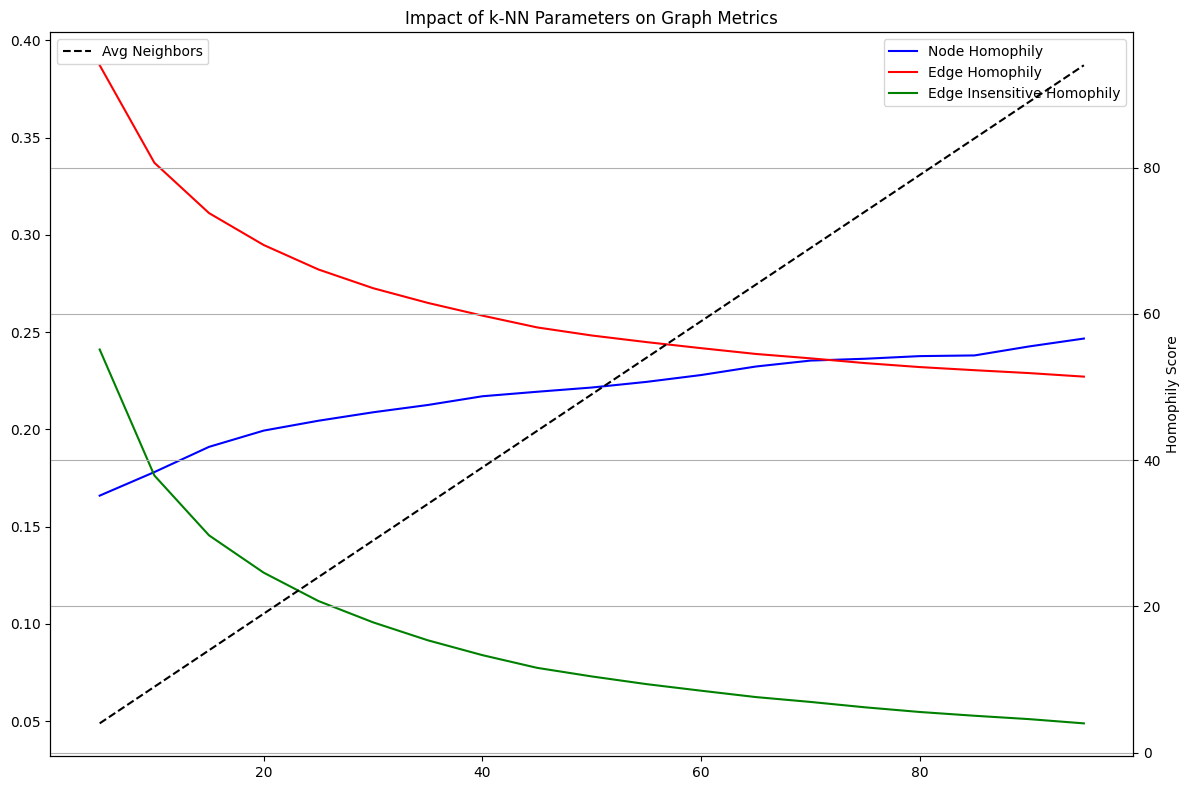


KNN Graph Statistics:
Best Node Homophily: 0.2467
Best Edge Homophily: 0.3873
Best Edge Insensitive Homophily: 0.2411

Number of edges for selected k values:
k=5: 10832 edges
k=10: 24372 edges
k=15: 37912 edges
k=20: 51452 edges
k=25: 64992 edges
k=30: 78532 edges
k=35: 92072 edges
k=40: 105612 edges
k=45: 119152 edges
k=50: 132692 edges
k=55: 146232 edges
k=60: 159772 edges
k=65: 173312 edges
k=70: 186852 edges
k=75: 200392 edges
k=80: 213932 edges
k=85: 227472 edges
k=90: 241012 edges
k=95: 254552 edges


In [ ]:
# Generate k values
k_values = np.arange(5, 100, 5)  # from 5 to 100 with step 5

# Calculate metrics
edge_index, node_homophily, edge_homophily, edge_insensitive_homophily, avg_neighbors, num_edges = create_knn_graph(data.x, data.y, k_values)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot homophily metrics on primary y-axis
plt.plot(k_values, node_homophily, 'b-', label='Node Homophily')
plt.plot(k_values, edge_homophily, 'r-', label='Edge Homophily')
plt.plot(k_values, edge_insensitive_homophily, 'g-', label='Edge Insensitive Homophily')
plt.legend()
# Add average neighbors on secondary y-axis
ax2 = plt.gca().twinx()
ax2.plot(k_values, avg_neighbors, 'k--', label='Avg Neighbors')
ax2.set_ylabel('Average Number of Neighbors', color='k')

# Customize the plot
plt.gca().set_xlabel('Number of Neighbors (k)')
plt.gca().set_ylabel('Homophily Score')
plt.title('Impact of k-NN Parameters on Graph Metrics')

# Combine legends from both axes
lines1, labels1 = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.grid(True)
# plot legend at the cleft corner
plt.legend(loc='upper left')


plt.tight_layout()
plt.show()

# Print summary statistics
print("\nKNN Graph Statistics:")
print(f"Best Node Homophily: {max(node_homophily):.4f}")
print(f"Best Edge Homophily: {max(edge_homophily):.4f}")
print(f"Best Edge Insensitive Homophily: {max(edge_insensitive_homophily):.4f}")
print("\nNumber of edges for selected k values:")
for k, edges in zip(k_values, num_edges):
    print(f"k={k}: {edges} edges")

### H-based DTrees

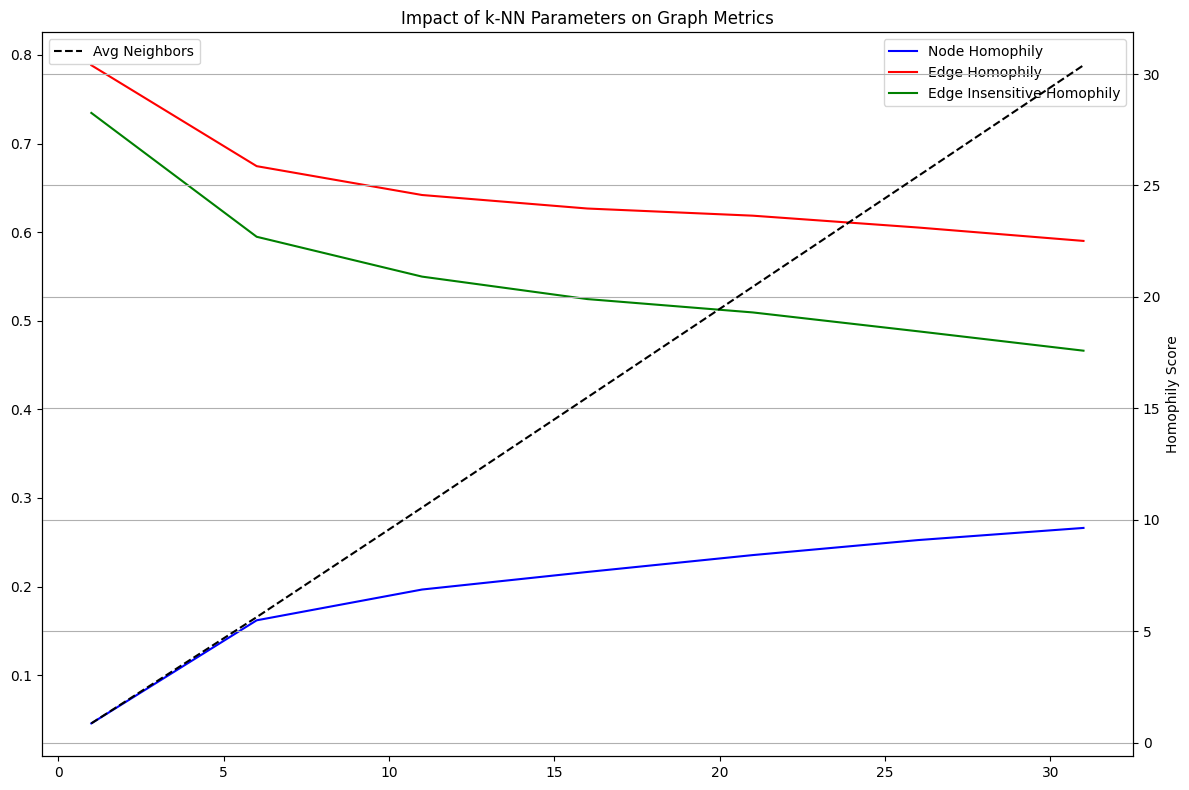


KNN Graph Statistics:
Best Node Homophily: 0.2662
Best Edge Homophily: 0.7884
Best Edge Insensitive Homophily: 0.7345

Number of edges for selected k values:
k=1: 2353 edges
k=6: 15261 edges
k=11: 28571 edges
k=16: 41961 edges
k=21: 55393 edges
k=26: 68842 edges
k=31: 82306 edges


In [16]:
dtree = sklearn.tree.DecisionTreeClassifier(
    #min_samples_leaf=5,
    #min_samples_split=50,
    #max_features='sqrt',
)

x = data.x[data.train_mask].numpy()
y = data.y[data.train_mask].numpy()

dtree.fit(x, y)

# Get decision paths from each tree
idx = torch.concatenate([data.train_mask, data.val_mask, data.test_mask])
X = data.x[idx]
y = data.y[idx]

H = torch.Tensor(dtree.decision_path(X).todense())
# Generate k values
k_values = np.arange(1, 35, 5)  # from 5 to 100 with step 5

# Calculate metrics
edge_index, node_homophily, edge_homophily, edge_insensitive_homophily, avg_neighbors, num_edges = create_knn_graph(H, y, k_values)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot homophily metrics on primary y-axis
plt.plot(k_values, node_homophily, 'b-', label='Node Homophily')
plt.plot(k_values, edge_homophily, 'r-', label='Edge Homophily')
plt.plot(k_values, edge_insensitive_homophily, 'g-', label='Edge Insensitive Homophily')
plt.legend()
# Add average neighbors on secondary y-axis
ax2 = plt.gca().twinx()
ax2.plot(k_values, avg_neighbors, 'k--', label='Avg Neighbors')
ax2.set_ylabel('Average Number of Neighbors', color='k')

# Customize the plot
plt.gca().set_xlabel('Number of Neighbors (k)')
plt.gca().set_ylabel('Homophily Score')
plt.title('Impact of k-NN Parameters on Graph Metrics')

# Combine legends from both axes
lines1, labels1 = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.grid(True)
# plot legend at the cleft corner
plt.legend(loc='upper left')


plt.tight_layout()
plt.show()

# Print summary statistics
print("\nKNN Graph Statistics:")
print(f"Best Node Homophily: {max(node_homophily):.4f}")
print(f"Best Edge Homophily: {max(edge_homophily):.4f}")
print(f"Best Edge Insensitive Homophily: {max(edge_insensitive_homophily):.4f}")
print("\nNumber of edges for selected k values:")
for k, edges in zip(k_values, num_edges):
    print(f"k={k}: {edges} edges")

torch.Size([2708, 709])

In [37]:
H.shape

torch.Size([2708, 709])

In [35]:
sum(y[edge_index[0]] == y[edge_index[1]]) / edge_index.shape[1]

tensor(0.6760)

In [ ]:



# from sklearn.metrics import jaccard_score
def own_jaccard_score(x, y):
    x = np.nonzero(x)[0]
    y = np.nonzero(y)[0]
    
    len_i, len_j = len(x), len(y)
    
    
    if len_j > len_i:
        score = jaccard_score(x, y[:len_i], average='micro')
    elif len_j < len_i:
        score =jaccard_score(x[:len_j], y, average='micro')
    else:
        score = jaccard_score(x, y, average='micro')
    return 1 - score


x = data.x[data.train_mask].numpy()
# y = data.y[data.train_mask].numpy()

from sklearn.metrics import jaccard_score

neigh = NearestNeighbors(n_neighbors=5, metric=lambda a,b: 1 - jaccard_score(a,b))
neigh.fit(x)

# Get decision paths from each tree
idx = torch.concatenate([data.train_mask, data.val_mask, data.test_mask])
X = data.x[idx]
y = data.y[idx]

# Get neighbors
distances, indices = neigh.kneighbors(X)

# Create edge list
edge_list = []
for i in range(len(X)):
    for neighbor in indices[i]:
        if i != neighbor:
            edge_list.append([i, neighbor])

# Convert to PyTorch tensor
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
sum(y[edge_index[0]] == y[edge_index[1]]) / edge_index.shape[1]


tensor(0.3467)

In [61]:
node_homo = homophily(edge_index, y, method='node')
node_homo

0.17838215827941895

0.6666666666666667

### KNN in the space of random forest


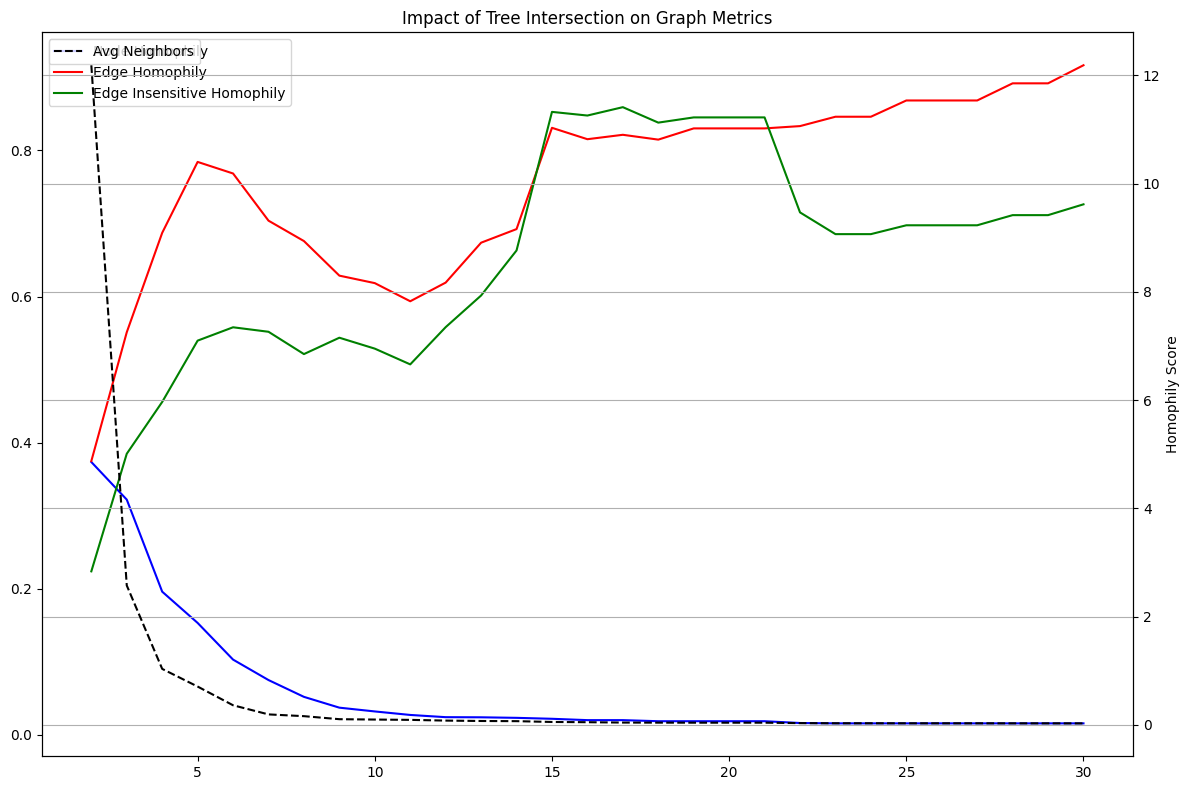


Intersection Method Statistics:
Best Node Homophily: 0.3734
Best Edge Homophily: 0.9167
Best Edge Insensitive Homophily: 0.8593

Number of common edges for each intersection:
Trees 1-2: 16500 edges
Trees 1-3: 3486 edges
Trees 1-4: 1397 edges
Trees 1-5: 955 edges
Trees 1-6: 488 edges
Trees 1-7: 260 edges
Trees 1-8: 216 edges
Trees 1-9: 140 edges
Trees 1-10: 131 edges
Trees 1-11: 123 edges
Trees 1-12: 105 edges
Trees 1-13: 95 edges
Trees 1-14: 91 edges
Trees 1-15: 71 edges
Trees 1-16: 65 edges
Trees 1-17: 56 edges
Trees 1-18: 54 edges
Trees 1-19: 53 edges
Trees 1-20: 53 edges
Trees 1-21: 53 edges
Trees 1-22: 42 edges
Trees 1-23: 39 edges
Trees 1-24: 39 edges
Trees 1-25: 38 edges
Trees 1-26: 38 edges
Trees 1-27: 38 edges
Trees 1-28: 37 edges
Trees 1-29: 37 edges
Trees 1-30: 36 edges


In [32]:
def infer_edges(X, k_value):
    """Create KNN graphs for different k values and calculate metrics"""
    
    # Initialize and fit KNN
    neigh = NearestNeighbors(n_neighbors=k_value, metric='hamming')
    neigh.fit(X)
    
    # Get neighbors
    distances, indices = neigh.kneighbors(X)
    
    # Create edge list
    edge_list = []
    for i in range(len(X)):
        for neighbor in indices[i]:
            if i != neighbor:
                edge_list.append([i, neighbor])
    
    # Convert to PyTorch tensor
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    
        
        
    return edge_index


def get_edge_set(edge_index):
    """Convert edge_index to a set of tuples for intersection operations"""
    return set(map(tuple, edge_index.T.tolist()))

# Get decision paths from each tree
idx = torch.concatenate([data.val_mask, data.test_mask])
X = data.x[idx]
y = data.y[idx]

dec_trees = [np.array(best_forest.estimators_[i].decision_path(X).todense()[:,:]) 
             for i in range(len(best_forest.estimators_))]

# Method 2: Intersection-based with incremental computation
dec_trees_tensor = [torch.Tensor(tree) for tree in dec_trees]


intersection_node_homophily = []
intersection_edge_homophily = []
intersection_edge_insensitive_homophily = []
intersection_avg_neighbors = []
num_common_edges = []

# Get initial edges from first tree
H = dec_trees_tensor[0]

k_values=100
edge_index =  infer_edges(H, k_values)
common_edges = get_edge_set(edge_index)

# Process remaining trees incrementally
for i in range(1, len(dec_trees_tensor)):
    # Get edges for the next tree
    H = dec_trees_tensor[i]
    edge_index = infer_edges(H, k_values)
    tree_edges = get_edge_set(edge_index)
    
    # Update intersection with new tree
    common_edges = common_edges.intersection(tree_edges)
    num_common_edges.append(len(common_edges))
    
    # Convert to edge_index format
    if common_edges:
        common_edge_index = torch.tensor(list(common_edges)).T
        
        # Calculate metrics
        node_homo = homophily(common_edge_index, y, method='node')
        edge_homo = homophily(common_edge_index, y, method='edge')
        edge_insensitive_homo = homophily(common_edge_index, y, method='edge_insensitive')
        avg_neigh = to_dense_adj(common_edge_index).squeeze(0).sum(1).mean().item()
    else:
        node_homo = edge_homo = edge_insensitive_homo = avg_neigh = 0
        
    intersection_node_homophily.append(node_homo)
    intersection_edge_homophily.append(edge_homo)
    intersection_edge_insensitive_homophily.append(edge_insensitive_homo)
    intersection_avg_neighbors.append(avg_neigh)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot homophily metrics on primary y-axis
plt.plot(range(2, len(dec_trees_tensor) + 1), intersection_node_homophily, 'b-', label='Node Homophily')
plt.plot(range(2, len(dec_trees_tensor) + 1), intersection_edge_homophily, 'r-', label='Edge Homophily')
plt.plot(range(2, len(dec_trees_tensor) + 1), intersection_edge_insensitive_homophily, 'g-', 
         label='Edge Insensitive Homophily')
plt.legend()
# Add average neighbors on secondary y-axis
ax2 = plt.gca().twinx()
ax2.plot(range(2, len(dec_trees_tensor) + 1), intersection_avg_neighbors, 'k--', label='Avg Neighbors')
ax2.set_ylabel('Average Number of Neighbors', color='k')

# Customize the plot
plt.gca().set_xlabel('Number of Trees in Intersection')
plt.gca().set_ylabel('Homophily Score')
plt.title('Impact of Tree Intersection on Graph Metrics')

# Combine legends from both axes
lines1, labels1 = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper left')
plt.show()

# Print summary statistics
print("\nIntersection Method Statistics:")
print(f"Best Node Homophily: {max(intersection_node_homophily):.4f}")
print(f"Best Edge Homophily: {max(intersection_edge_homophily):.4f}")
print(f"Best Edge Insensitive Homophily: {max(intersection_edge_insensitive_homophily):.4f}")

print("\nNumber of common edges for each intersection:")
for i, num in enumerate(num_common_edges, 2):
    print(f"Trees 1-{i}: {num} edges")





In [29]:
a = data.y[torch.Tensor(list(common_edges)).long()]
sum(a[:, 0] == a[:, 1])/a.shape[0]

tensor(0.1667)

### **Leak** of the labels into training but restrict the tree hence it doesnt have capacity to learn the whole training set

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Split train and validation data
x_train = data.x.numpy()
y_train = data.y.numpy()
x_val = data.x.numpy()
y_val = data.y.numpy()

# Define the parameter grid for DecisionTreeClassifier
param_grid = {
    'criterion': ['gini', 'entropy'],                # Splitting criterion
    'max_depth': [None, 5, 10, 20],                  # Maximum tree depth
    'min_samples_split': [2, 5, 10, 20],             # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 5, 10],               # Minimum samples in a leaf node
    'max_features': [None, 'sqrt', 'log2'],          # Features to consider for best split
    'class_weight': [None, 'balanced'],              # Balance class weights
}

# NOT RESTRICTED TREE
# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None],  # Allow unlimited depth
#     'min_samples_split': [2],  # Minimum possible value
#     'min_samples_leaf': [1],  # Minimum possible value
#     'max_features': [None],  # Use all features
#     'class_weight': [None, 'balanced']
# }

# Initialize a DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=42,
                               min_impurity_decrease=0.0  # Allow s
                               )

# Initialize GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    verbose=1   # Display progress
)

# Perform the search on the training data
grid_search.fit(x_train, y_train)

# Get the best estimator and hyperparameters
best_tree = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate on the validation data
y_pred = best_tree.predict(x_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy with Best Hyperparameters: {accuracy:.4f}")

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


Best Hyperparameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 20}
Validation Accuracy with Best Hyperparameters: 0.7718


In [34]:
dpath = best_tree.decision_path(data.x.numpy())
H = torch.Tensor(dpath.todense()[:,:]) 
edge_index = construct_edge_index_optimized(H, H.shape[1])


print("Edge Index:", edge_index.shape)
print("Num neigh", torch_geometric.utils.to_dense_adj(edge_index).squeeze(0).sum(1))
print("Node homo:", torch_geometric.utils.homophily(edge_index, data.y, method='node'))
print("Edge homo:",torch_geometric.utils.homophily(edge_index, data.y, method='edge'))
print("Edge_insensitive homo:",torch_geometric.utils.homophily(edge_index, data.y, method='edge_insensitive'))

Edge Index: torch.Size([2, 85326])
Num neigh tensor([24.,  7.,  6.,  ...,  5.,  4., 24.])
Node homo: 0.6542190909385681
Edge homo: 0.8818882703781128
Edge_insensitive homo: 0.7202354073524475
